## Evaluating the system performance

This notebook evaluates the performance of the system by comparing the ranked list of pieces with the ground truth for each query.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
import pickle
import random

In [4]:
def readGroundTruthLabels(gtfile):
    d={}
    d1={}
    with open(gtfile, "r") as f:
        for line in f:
            data = line.split(',')
            key = data[0]
            d[key] = []
            d1[key] = key
            for idx,item in enumerate(data):
                if idx != 0 and item != "x":
                    try:
                        pieceNum = int(item)
                        d[key].append(pieceNum)
                    except:
                        pass
                    try:
                        pieceNum = int(item)
                        d1[str(pieceNum)] = key
                    except:
                        pass
    return d, d1

In [5]:
def readHypothesisFiles(hypdir, benchmark):
    l = []
    for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
#         print(hypfile)
        with open(hypfile, "rb") as f:
            l.append(pickle.load(f))
    return l

In [6]:
s = set([])
def collapseIds(pieceScores):
    pieceScores = list(dict.fromkeys(pieceScores))
    return pieceScores
        

In [67]:
def getRank(pieceScores,gt,idt,queryid, benchmark, condition):
    l = []
    count = 0
    rank = 300000
    for i in range(len(pieceScores)):
        if pieceScores[i][0][0]=='p':
            if(pieceScores[i][0]==queryid.split('_')[0]):
                rank=count+1
                return rank
            if not pieceScores[i][0] in idt.keys():
                count+=1
            elif not idt[pieceScores[i][0]] in l:
                count+=1
                l.append(idt[idt[pieceScores[i][0]]])
        else:
            try:
                if (int(pieceScores[i][0].split("_")[-1]) in gt[query]):
                    rank = count+1
                    return rank

                if not str(int(pieceScores[i][0].split("_")[-1])) in idt.keys():
                    count+=1
                elif not idt[str(int(pieceScores[i][0].split("_")[-1]))] in l:
                    count+=1
                    l.append(idt[str(int(pieceScores[i][0].split("_")[-1]))])
            except:
                pass
    return rank

In [73]:
def calcPrecisionRecall(hypdir, gtfile, benchmark = False, condition = 1):
    """Inputs: a directory containing the ranked list of pieces from the marketplace fingerprinting system,
               and a file containing the ground truth mapping for each query and the correct IMSLP piece.
               
       Outputs: the MRR for all the predictions, a list of ranks for each query, a list of runtimes for 
                each query, and the number of matches processed for each query."""
    hyps = readHypothesisFiles(hypdir, benchmark)
    gt,idt = readGroundTruthLabels(gtfile)
    MRR = 0
    runtimes = []
    MRRs = []
    matches = []
    hyps = np.array(sorted(hyps, key = lambda x: int(x[0].split("_")[0][1:])*100+int(x[0].split("_")[1][1:])), dtype=object)
    count = 0
    if hyps.shape[1] == 2:
        for queryid, pieceScores in hyps:
            rank = getRank(pieceScores,gt,idt,queryid,dataset, benchmark, condition)
            MRRs.append((queryid,rank))
            MRR=MRR+1/(rank)
    else:
        for queryid, pieceScores, runtime, matches_processed in hyps:
            rank = getRank(pieceScores,gt,idt,queryid, benchmark, condition)
            MRRs.append((queryid,rank))
            runtimes.append(runtime)
            MRR=MRR+1/(rank)
            matches.append(matches_processed)
    return MRR/len(MRRs),MRRs, runtimes, matches

In [74]:
def calcOverlap(seg1, seg2):
    overlap_lb = max(seg1[0], seg2[0])
    overlap_ub = min(seg1[1], seg2[1])
    overlap = np.clip(overlap_ub - overlap_lb, 0, None)
    return overlap    

In [75]:
hypdir = 'old_experiments/v0.4.0d_1k_budget/hyp'
benchmark = 0
queryGTFile = 'piece_To_id.csv'
correct_matches = {}
MRR, MRRs, runtimes, matches_processed = calcPrecisionRecall(hypdir, queryGTFile, benchmark, condition = 1)

In [78]:
hypdir = 'experiments/scannedDataset/hyp'
benchmark = 0
queryGTFile = 'piece_To_id.csv'
correct_matches = {}
MRR, MRRs, runtimes, matches_processed = calcPrecisionRecall(hypdir, queryGTFile, benchmark, condition = 1)

In [79]:
MRR

0.9907834254992319

### Investigate Errors

This prints the individual ranks for each query.

In [81]:
def printDebuggingInfo(MRRs):
    for i, (queryid, rank) in enumerate(MRRs):
        print(queryid, rank)

In [82]:
printDebuggingInfo(MRRs)

p1_q0 1
p1_q1 1
p1_q2 1
p1_q3 1
p5_q0 1
p5_q1 1
p5_q2 1
p5_q3 1
p5_q4 1
p5_q5 1
p11_q0 1
p11_q1 1
p11_q2 1
p11_q3 1
p11_q4 1
p11_q5 1
p11_q6 1
p11_q7 1
p11_q8 1
p11_q9 1
p11_q10 1
p11_q11 1
p11_q12 1
p15_q0 1
p15_q1 1
p15_q2 1
p15_q3 1
p21_q0 1
p21_q1 1
p21_q2 1
p21_q3 1
p21_q4 1
p21_q5 1
p21_q6 1
p21_q7 1
p21_q8 1
p25_q0 1
p25_q1 1
p31_q0 1
p31_q1 1
p31_q2 1
p31_q3 1
p35_q0 1
p35_q1 1
p41_q0 1
p41_q1 1
p45_q0 1
p45_q1 1
p45_q2 1
p45_q3 1
p51_q0 1
p51_q1 1
p55_q0 1
p55_q1 1
p55_q2 1
p61_q0 1
p61_q1 1
p61_q2 1
p61_q3 1
p61_q4 1
p61_q5 1
p61_q6 1
p61_q7 1
p61_q8 1
p61_q9 1
p61_q10 1
p65_q0 1
p65_q1 1
p65_q2 1
p71_q0 1
p71_q1 1
p75_q0 1
p75_q1 1
p75_q2 1
p81_q0 1
p81_q1 1
p81_q2 1
p81_q3 1
p81_q4 1
p81_q5 1
p81_q6 1
p81_q7 1
p81_q8 1
p85_q0 1
p85_q1 1
p85_q2 1
p85_q3 1
p85_q4 1
p91_q0 1
p91_q1 1
p91_q2 1
p91_q3 1
p91_q4 1
p91_q5 1
p91_q6 1
p95_q0 1
p95_q1 1
p95_q2 1
p101_q0 1
p101_q1 1
p101_q2 1
p105_q0 1
p105_q1 1
p105_q2 1
p105_q3 1
p105_q4 1
p105_q5 1
p105_q6 1
p111_q0 1
p111_q1 1
p115

### Measure Runtime

In [83]:
def showRuntimeStats(durs):
    durs = np.array(durs)
    avgDur = np.mean(durs)
    minDur = np.min(durs)
    maxDur = np.max(durs)
    stdDur = np.std(durs)
    print('Avg runtime: {:.2f} sec'.format(avgDur))
    print('Std runtime: {:.2f} sec'.format(stdDur))
    print('Min runtime: {:.2f} sec'.format(minDur))
    print('Max runtime: {:.2f} sec'.format(maxDur))
    plt.hist(durs, bins=np.arange(0,2,.1))
    plt.xlabel('Runtime (sec)')
    plt.ylabel('Count')

Avg runtime: 1.35 sec
Std runtime: 0.36 sec
Min runtime: 0.77 sec
Max runtime: 4.41 sec


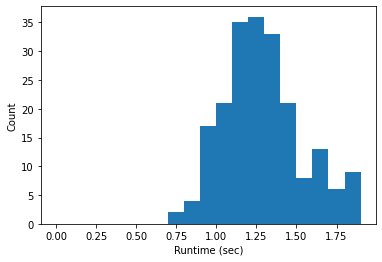

In [84]:
showRuntimeStats(runtimes)

### Measure matches processed

In [ ]:
def showMatchStats(matchesProcessed):
    matches = np.array(matchesProcessed)
    avgMatches = np.mean(matches)
    minMatches = np.min(matches)
    maxMatches = np.max(matches)
    stdMatches = np.std(matches)
    print(f'Avg matches: {avgMatches}')
    print(f'Std matches: {stdMatches}')
    print(f'Min matches: {minMatches}')
    print(f'Max matches: {maxMatches}')
    plt.hist(matches)
    plt.xlabel('Number of matches processed')
    plt.ylabel('Count')

In [ ]:
showMatchStats(matches_processed)